# 01 — Data Exploration (IBIT + BTC + Mining Cost)

This notebook focuses on:
- Data integrity checks
- Basic exploratory charts
- Return / volatility / drawdown views
- IBIT vs BTC relationship
- Mining cost vs price context

Rules:
- Long-only context (for later)
- No leverage (for later)
- 365-day annualization

In [1]:
# --- Project path setup (run first) ---
import sys
from pathlib import Path

ROOT = Path.cwd()
if (ROOT / "config.py").exists():
    PROJECT_ROOT = ROOT
elif (ROOT.parent / "config.py").exists():
    PROJECT_ROOT = ROOT.parent
else:
    PROJECT_ROOT = ROOT

sys.path.insert(0, str(PROJECT_ROOT))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import Data.raw_data_loader as rdl
importlib.reload(rdl)
from Data.raw_data_loader import load_ibit_with_mining_cost

from config import *
from Data.raw_data_loader import load_raw_crypto_csv, load_ibit_with_mining_cost

In [2]:
# --- Load data ---
# IBIT + mining cost aligned
mining_df = load_ibit_with_mining_cost(
    ibit_path=IBIT_PATH,
    cleaned_crypto_path=DATA_PATH,
    forward_fill_mining_cost=True,
).rename(columns={"close": PRICE_COLUMN_IBIT, "mining_cost": COST_COLUMN_MINE})

# BTC (and other assets from cleaned_crypto_data.csv)
df_crypto = load_raw_crypto_csv(DATA_PATH, start_date=DATA_START_DATE)

display(mining_df.head())
display(df_crypto.head())

,IBIT_close,COST_TO_MINE
date,,
2024-01-11,26.63,38865.4335
2024-01-12,24.97,39503.8137
2024-01-16,24.72,36461.3437
2024-01-17,24.41,37085.1762
2024-01-18,23.34,38133.0705


,BTC-USD_open,BTC-USD_high,BTC-USD_low,BTC-USD_close,BTC-USD_volume,BTC_REWARD,COST_TO_MINE,ETH-USD_open,ETH-USD_high,ETH-USD_low,ETH-USD_close,ETH-USD_volume
Date,,,,,,,,,,,,
2017-11-01,6440.970215,6767.310059,6377.879883,6767.310059,2.870320e+09,12.5,2318.8721,314.690002,319.153015,298.513,307.907989,1.613480e+09
2017-11-02,6777.770020,7367.330078,6758.720215,7078.500000,4.653770e+09,12.5,2372.8628,314.690002,319.153015,298.513,307.907989,1.613480e+09
2017-11-03,7087.529785,7461.290039,7002.939941,7207.759766,3.369860e+09,12.5,2417.9520,314.690002,319.153015,298.513,307.907989,1.613480e+09
2017-11-04,7164.479980,7492.859863,7031.279785,7379.950195,2.483800e+09,12.5,2461.1774,314.690002,319.153015,298.513,307.907989,1.613480e+09
2017-11-05,7404.520020,7617.479980,7333.189941,7407.410156,2.380410e+09,12.5,2407.5585,314.690002,319.153015,298.513,307.907989,1.613480e+09


In [3]:
# --- Quick integrity checks ---
def basic_checks(df: pd.DataFrame, cols):
    out = {}
    for c in cols:
        s = df[c].astype(float)
        out[c] = {
            "n": int(s.shape[0]),
            "na": int(s.isna().sum()),
            "min": float(np.nanmin(s.values)),
            "max": float(np.nanmax(s.values)),
        }
    return pd.DataFrame(out).T

print("IBIT checks")
display(basic_checks(mining_df, [PRICE_COLUMN_IBIT, COST_COLUMN_MINE]))

print("BTC checks")
display(basic_checks(df_crypto, [PRICE_COLUMN_BTC]))

IBIT checks


,n,na,min,max
IBIT_close,532.0,0.0,22.320000,71.290
COST_TO_MINE,532.0,0.0,112.621063,102352.707


BTC checks


,n,na,min,max
BTC-USD_close,3020.0,0.0,3236.761719,125424.2578


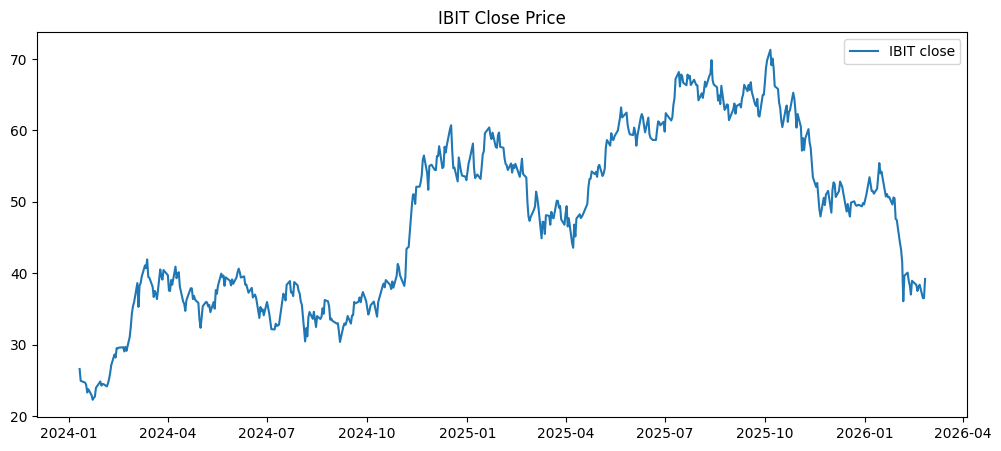

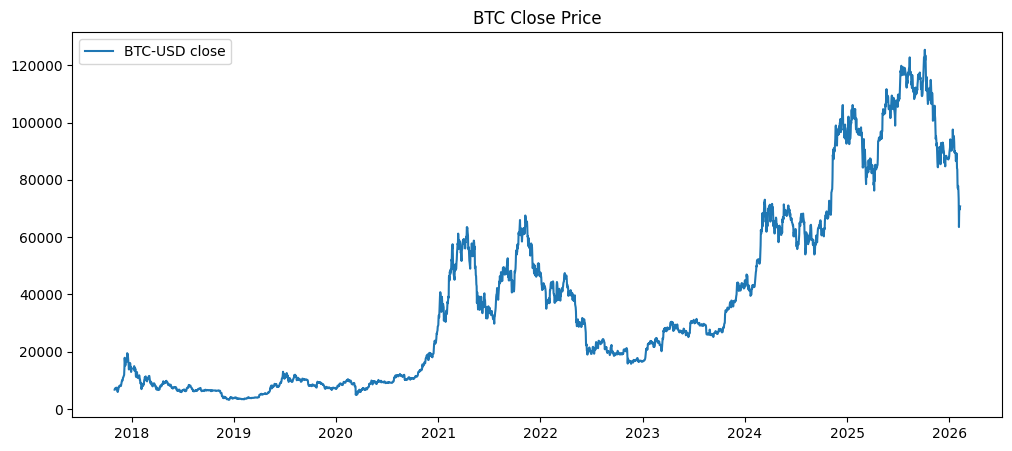

In [4]:
# --- Price charts ---
plt.figure(figsize=(12, 5))
plt.plot(mining_df.index, mining_df[PRICE_COLUMN_IBIT], label="IBIT close")
plt.title("IBIT Close Price")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(df_crypto.index, df_crypto[PRICE_COLUMN_BTC], label="BTC-USD close")
plt.title("BTC Close Price")
plt.legend()
plt.show()

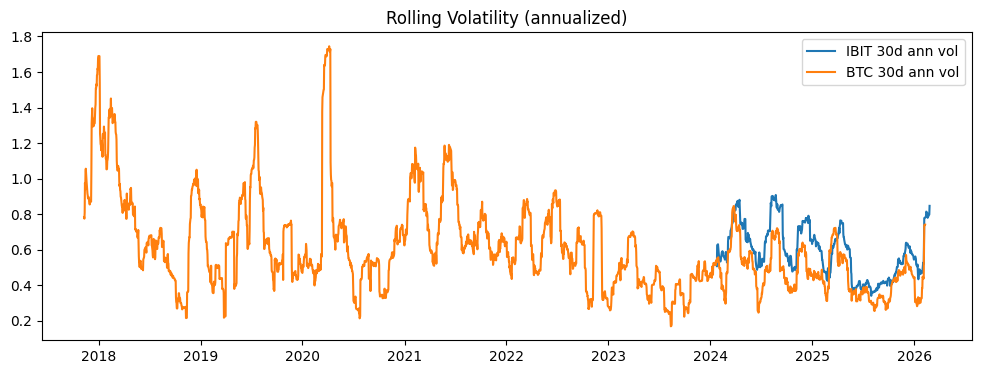

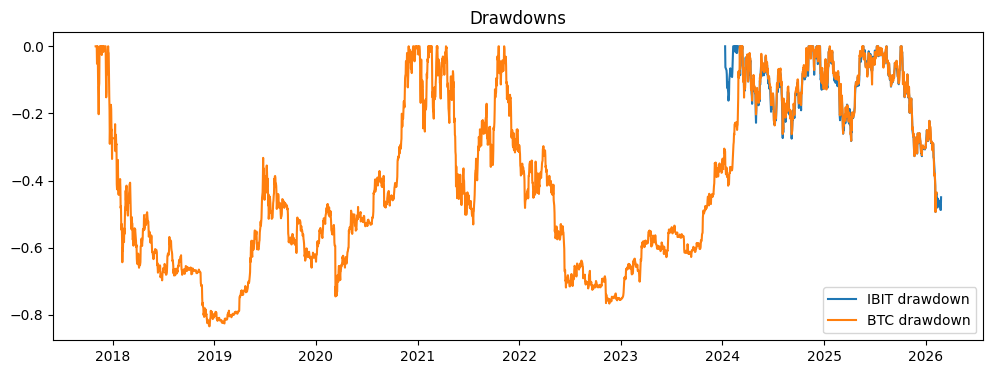

In [5]:
# --- Returns, rolling vol, drawdown ---
def compute_returns(price: pd.Series) -> pd.Series:
    return price.astype(float).pct_change().fillna(0.0)

def rolling_vol(ret: pd.Series, window: int = 30) -> pd.Series:
    return ret.rolling(window, min_periods=max(3, window // 3)).std() * np.sqrt(DAYS_PER_YEAR)

def equity_curve(ret: pd.Series) -> pd.Series:
    return (1.0 + ret).cumprod()

def drawdown(eq: pd.Series) -> pd.Series:
    peak = eq.cummax()
    return eq / peak - 1.0

r_ibit = compute_returns(mining_df[PRICE_COLUMN_IBIT])
r_btc = compute_returns(df_crypto[PRICE_COLUMN_BTC])

eq_ibit = equity_curve(r_ibit)
eq_btc = equity_curve(r_btc)

dd_ibit = drawdown(eq_ibit)
dd_btc = drawdown(eq_btc)

plt.figure(figsize=(12, 4))
plt.plot(rolling_vol(r_ibit, 30), label="IBIT 30d ann vol")
plt.plot(rolling_vol(r_btc, 30), label="BTC 30d ann vol")
plt.title("Rolling Volatility (annualized)")
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(dd_ibit, label="IBIT drawdown")
plt.plot(dd_btc, label="BTC drawdown")
plt.title("Drawdowns")
plt.legend()
plt.show()

Return correlation (daily): 0.9232192770363805


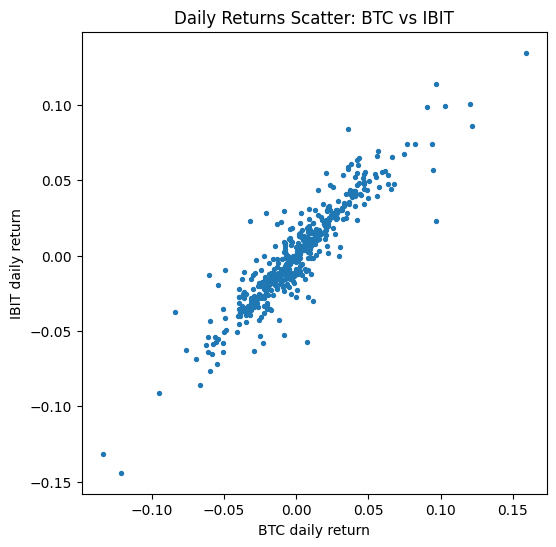

In [6]:
# --- IBIT vs BTC relationship ---
# Align on common dates
aligned = pd.DataFrame({
    "IBIT": mining_df[PRICE_COLUMN_IBIT],
    "BTC": df_crypto[PRICE_COLUMN_BTC],
}).dropna()

# Correlation of daily returns
corr = aligned.pct_change().dropna().corr().iloc[0, 1]
print("Return correlation (daily):", float(corr))

plt.figure(figsize=(6, 6))
plt.scatter(aligned["BTC"].pct_change(), aligned["IBIT"].pct_change(), s=8)
plt.title("Daily Returns Scatter: BTC vs IBIT")
plt.xlabel("BTC daily return")
plt.ylabel("IBIT daily return")
plt.show()

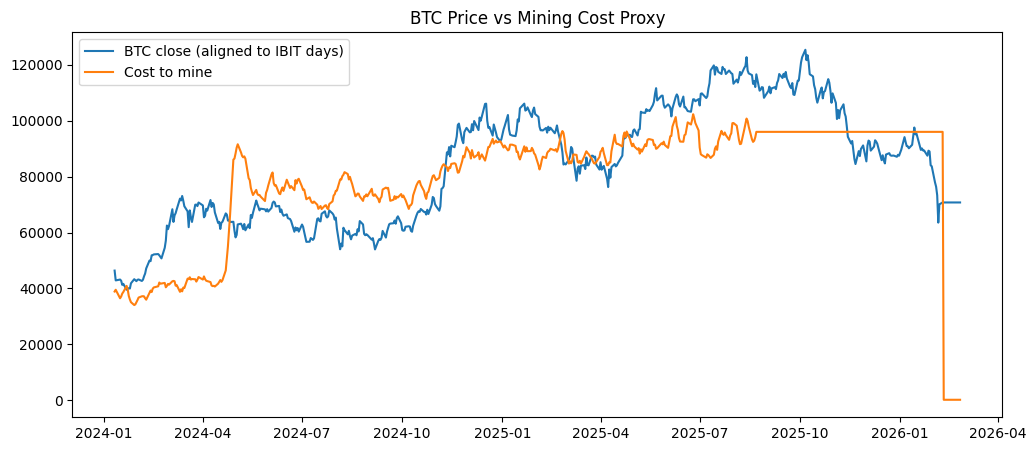

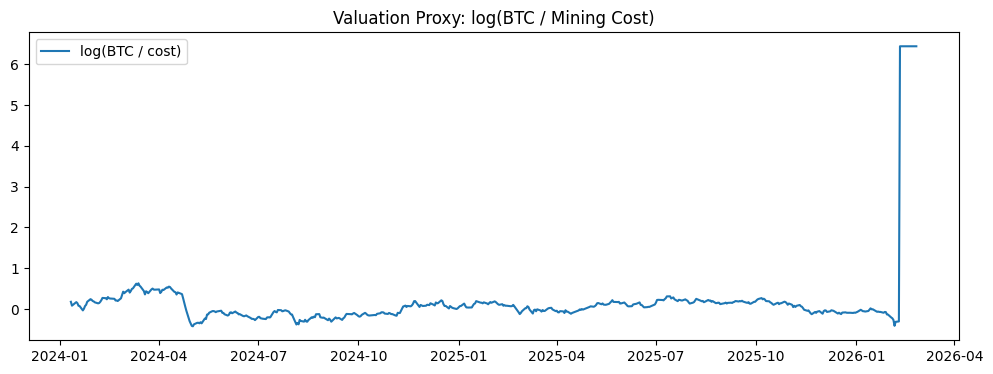

In [7]:
# --- BTC vs Mining Cost (better apples-to-apples) ---
btc_on_ibit_days = df_crypto[PRICE_COLUMN_BTC].reindex(mining_df.index).ffill()

cost = mining_df[COST_COLUMN_MINE].astype(float).copy()
cost = cost.where(cost > 0).ffill()  # safety even if loader isn’t fixed yet

plt.figure(figsize=(12, 5))
plt.plot(btc_on_ibit_days.index, btc_on_ibit_days.values, label="BTC close (aligned to IBIT days)")
plt.plot(cost.index, cost.values, label="Cost to mine")
plt.title("BTC Price vs Mining Cost Proxy")
plt.legend()
plt.show()

log_ratio_btc = np.log(btc_on_ibit_days / cost).replace([np.inf, -np.inf], np.nan)

plt.figure(figsize=(12, 4))
plt.plot(log_ratio_btc.index, log_ratio_btc.values, label="log(BTC / cost)")
plt.title("Valuation Proxy: log(BTC / Mining Cost)")
plt.legend()
plt.show()